## Model Training

We will train and deploy a Yolov3 model from the GluonCV model zoo. In the advance course we will get much deeper into GluonCV and the structure of the Yolov3 neural network.

You can checkout gluoncv and learn more about other models in the gluoncv model zoo here: https://gluon-cv.mxnet.io/

In [12]:
!pip install gluoncv --quiet

You are using pip version 10.0.1, however version 20.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
#This script will configure our notebook instance for local training, run this command from terminal in scripts folder
#!sh setup.sh

In [13]:
import mxnet as mx
import gluoncv as gcv
import numpy as np
import subprocess

import boto3
import sagemaker

In [14]:
session = sagemaker.Session()
default_s3_bucket = 's3://{}'.format(session.default_bucket())
print('default_s3_bucket: {}'.format(default_s3_bucket))

training_images = session.upload_data('./data', key_prefix='data0429')

s3_output_path = '{}/'.format(default_s3_bucket)
print("S3 bucket path: {}".format(s3_output_path))

default_s3_bucket: s3://sagemaker-us-east-1-366338342029
S3 bucket path: s3://sagemaker-us-east-1-366338342029/


## Create a SageMaker HPO Job

Now that we have completed our local testing, lets spin up an HPO job outside of our notebook and optimize our hypterparameters. With off notebook training we have the ability to scale compute up to large training clusters, based on our dataset size and complexity of our neural network.

In [15]:

#Again our hyperparamters
#Advanced class can look into the train_yolo.py code and add more.
static_hyperparameters = {
    'epochs' : 60
}

In [22]:
#Similar to above we need to define the parameters of our training jobs.
from sagemaker.mxnet.estimator import MXNet
role = sagemaker.get_execution_role()
base_job_name_prefix = 'yolo'
instance_type = "ml.c5.9xlarge"#"ml.p3.2xlarge" #"ml.c5.9xlarge"
estimator = MXNet(entry_point="./CV-Scripts/train_yolo.py",
                  role=role,
                  train_instance_type=instance_type,
                  train_instance_count=1,
                  output_path=s3_output_path,
                  framework_version="1.6.0",
                  py_version='py3',
                  base_job_name=base_job_name_prefix,
                  hyperparameters=static_hyperparameters
                 )

In [23]:
#Here we define how we will tune our hyperparameters
metric_definitions = [
    {'Name': 'validation_mAP', 'Regex': 'best mAP ([-+]?[0-9]*[.]?[0-9]+([eE][-+]?[0-9]+)?)'},
    {'Name': 'run_validation_mAP', 'Regex': 'running mAP ([-+]?[0-9]*[.]?[0-9]+([eE][-+]?[0-9]+)?)'}]

### This is where we set our hyperparameters

The following hyperparameters can be adjusted to improve our model's performance:
- Learning Rate (lr): controls how much should the model learn from the current iteration ( < 0.01 )
- Batch Size: contols how many chips in each learning iteration (> 1)
- Learning Rate Factor (lr_factor): how much to multiply the learning rate after 2/3 of training (0 < x < 1)
- Weight Detcal (wd): regularization to force small weights ( < 0.001 )
- Model

In [24]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {
    'lr': ContinuousParameter(0.0001, 0.005),
    'batch_size': IntegerParameter(2, 64),
    'lr_factor': ContinuousParameter(0.3, 1),
    'wd': ContinuousParameter(0.00001, 0.0002),
    'model': CategoricalParameter(["yolo3_darknet53_custom", "yolo3_mobilenet0.25_custom","yolo3_mobilenet1.0_custom"]),
}

In [25]:
#Max jobs is how many different training jobs we will do
max_jobs = 5
#How many we can run in parallel at once 
max_parallel_jobs = 5

In [26]:
#Now we provide the additional parameters that we can hypertune and how we will
# compare models
tuner = HyperparameterTuner(estimator,
                            objective_metric_name='validation_mAP',
                            objective_type='Maximize',
                            hyperparameter_ranges=hyperparameter_ranges,
                            metric_definitions=metric_definitions,
                            max_jobs=max_jobs,
                            max_parallel_jobs=max_parallel_jobs,
                            base_tuning_job_name=base_job_name_prefix
                           )

In [27]:
%%time

tuner.fit({"train":training_images})

CPU times: user 42.9 ms, sys: 7.71 ms, total: 50.6 ms
Wall time: 401 ms


In [28]:
tuning_job_name = tuner._current_job_name

In [32]:

sage_client = boto3.Session().client('sagemaker')

# run this cell to check current status of hyperparameter tuning job
tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)

status = tuning_job_result['HyperParameterTuningJobStatus']
if status != 'Completed':
    print('Reminder: the tuning job has not been completed.')
    
job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
print("%d training jobs have completed" % job_count)
    
is_minimize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Maximize')
objective_name = tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['MetricName']

5 training jobs have completed


In [33]:
from pprint import pprint
if tuning_job_result.get('BestTrainingJob',None):
    print("Best model found so far:")
    pprint(tuning_job_result['BestTrainingJob'])
else:
    print("No training jobs have reported results yet.")

Best model found so far:
{'CreationTime': datetime.datetime(2020, 5, 19, 20, 58, 8, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation_mAP',
                                                 'Value': 0.020769160240888596},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2020, 5, 19, 21, 24, 9, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:366338342029:training-job/yolo-200519-2057-005-77797006',
 'TrainingJobName': 'yolo-200519-2057-005-77797006',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2020, 5, 19, 21, 0, 26, tzinfo=tzlocal()),
 'TunedHyperParameters': {'batch_size': '58',
                          'lr': '0.0008650478978248947',
                          'lr_factor': '0.7900708570695081',
                          'model': '"yolo3_mobilenet1.0_custom"',
                          'wd': '0.00017685255273539884'}}


In [34]:
import pandas as pd

tuner_analytics = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

full_df = tuner_analytics.dataframe()

if len(full_df) > 0:
    df = full_df[full_df['FinalObjectiveValue'] > -float('inf')]
    if len(df) > 0:
        df = df.sort_values('FinalObjectiveValue', ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest":min(df['FinalObjectiveValue']),"highest": max(df['FinalObjectiveValue'])})
        pd.set_option('display.max_colwidth', -1)  # Don't truncate TrainingJobName        
    else:
        print("No training jobs have reported valid results yet.")

Number of training jobs with valid objective: 5
{'lowest': 0.01067916676402092, 'highest': 0.020769160240888596}


## Model Deployment and Evaluation

This next section of code will deploy our best model from the HPO job. You will want to wait until the tuning job completes before we deploy the model. Our goal is to understand how the model performs on the test image. Is it accurate enough? 

In [35]:
#Below we attempt to deploy the best job to a new instance type
deployed_model = tuner.deploy(1, 'ml.c5.4xlarge') 

#Below is commented out and is for use for moderators, or the advanced class
# it should be used if you lose the deploy model or your kernel has issues with above
#deployed_model = sagemaker.mxnet.model.MXNetPredictor(estimator_best_job.base_job_name,sagemaker_session=session)

2020-05-19 21:24:09 Starting - Preparing the instances for training
2020-05-19 21:24:09 Downloading - Downloading input data
2020-05-19 21:24:09 Training - Training image download completed. Training in progress.
2020-05-19 21:24:09 Uploading - Uploading generated training model
2020-05-19 21:24:09 Completed - Training job completed2020-05-19 21:00:56,264 sagemaker-containers INFO     Imported framework sagemaker_mxnet_container.training
2020-05-19 21:00:56,265 sagemaker-containers INFO     Failed to parse hyperparameter _tuning_objective_metric value validation_mAP to Json.
Returning the value itself
2020-05-19 21:00:56,267 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-05-19 21:00:56,279 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"batch_size":58,"epochs":60,"lr":0.0008650478978248947,"lr_factor":0.7900708570695081,"model":"yolo3_mobilenet1.0_cust

-------------!

In [9]:
#Lets load the image and scale it accordingly to transform.
x, image = gcv.data.transforms.presets.yolo.load_test('Bayonne_Crossing_Shopping Center_NJ440_6APR20_2.png', short=328)
#Send payload (our image) to the endpoint
output = deployed_model.predict(image)

NameError: name 'deployed_model' is not defined

In [38]:
output

{'cid': [[1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [5.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [11.0],
  [9.0],
  [5.0],
  [0.0],
  [3.0],
  [5.0],
  [10.0],
  [2.0],
  [8.0],
  [1.0],
  [4.0],
  [1.0],
  [1.0],
  [1.0],
  [7.0],
  [6.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [5.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [9.0],
  [3.0],
  [6.0],
  [1.0],
  [1.0],
  [2.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [7.0],
  [1.0],
  [1.0],
  [0.0],
  [1.0],
  [5.0],
  [1.0],
  [11.0],
  [4.0],
  [1.0],
  [1.0],
  [1.0],
  [1.0],
  [8.0],
  [1.0],
  [-1.0],
  [-1.0],
  [-1.0],
  [-1.0],
  [-1.0],
  [-1.0],
  [-1.0],
  [-1.0],
  [-1.0],
  [-1.0]],
 'score': [[0.07342435419559479],
  [0.06404158473014832],
  [0.049766749143600

In [39]:
#Classes inside of this dataset
classes = ['Passenger Vehicle',
                'Small Car',
                'Bus',
                'Pickup Truck',
                'Utility Truck',
                'Truck',
                'Cargo Truck',
                'Truck Tractor w/ Box Trailer',
                'Truck Tractor',
                'Trailer',
                'Truck Tractor w/ Flatbed Trailer',
                'Truck Tractor w/ Liquid Tank']

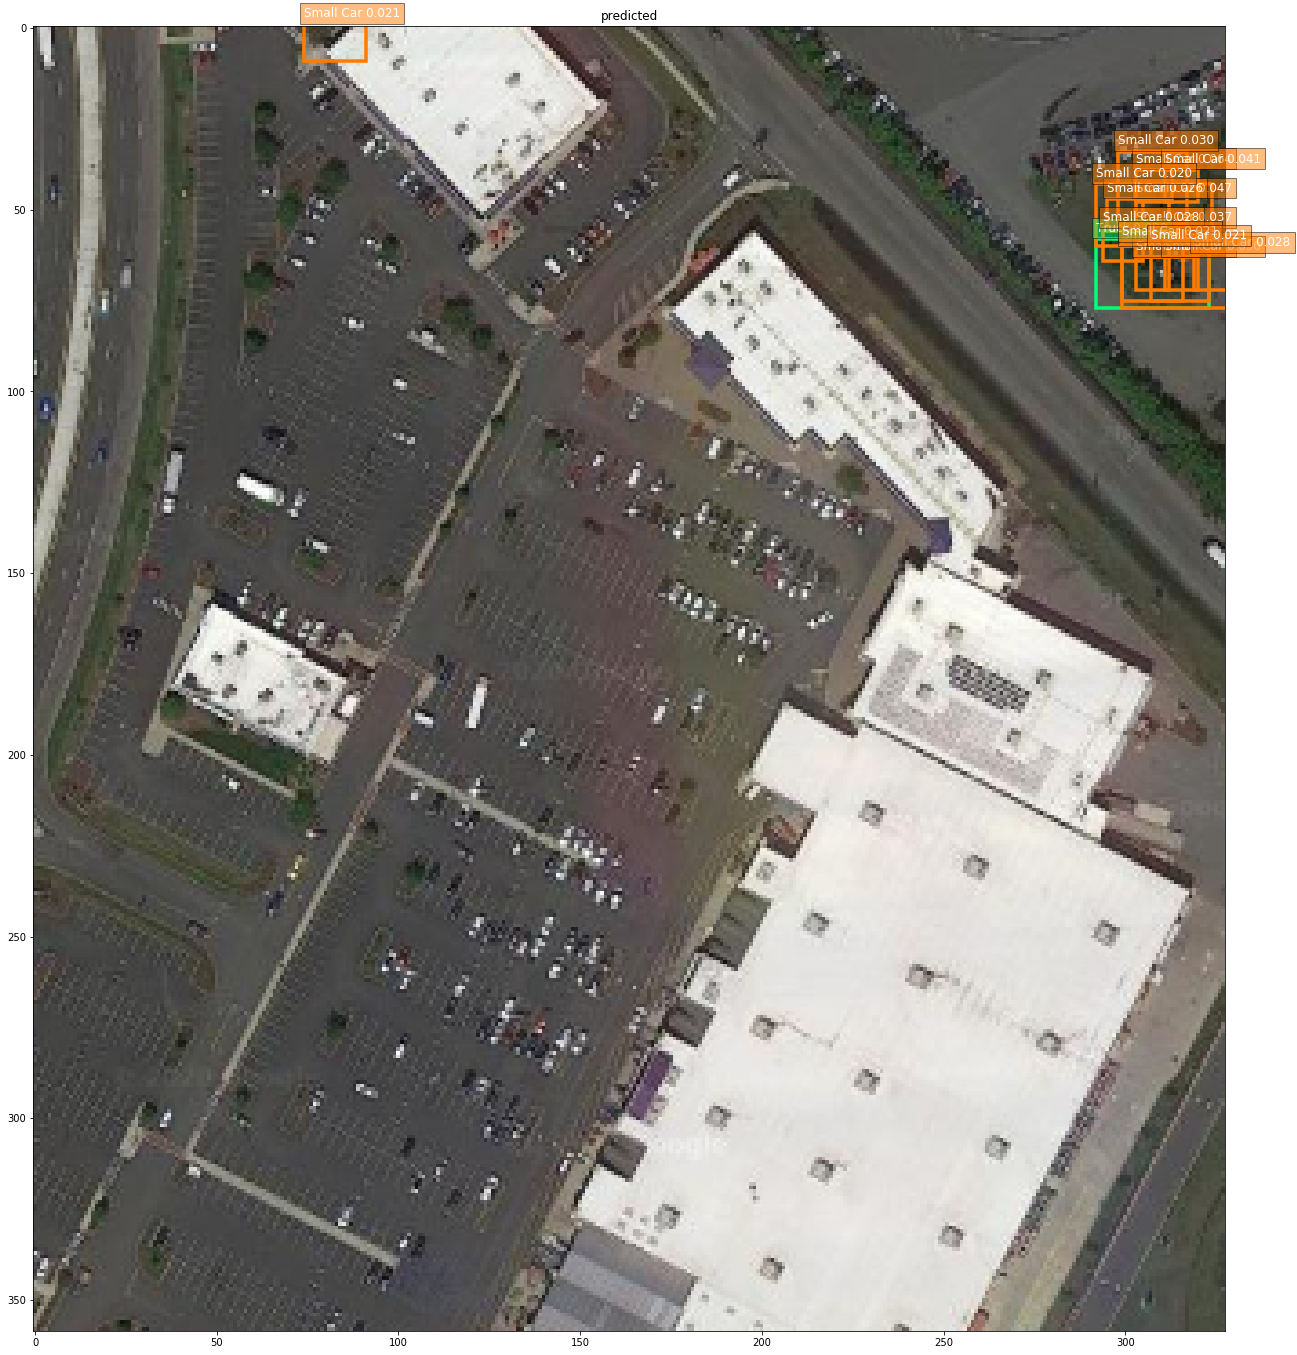

In [40]:
#lets plot the results we first load the true labels
import matplotlib.pyplot as plt
%matplotlib inline

#lbls = gcv.data.transforms.bbox.resize(np.load('./data/test-lbls.npy'),(208,208),(328,328))

cid = np.array(output['cid'])
scores = np.array(output['score'])
bbox = np.array(output['bbox'])

#On the left is our predictions, on the right is the ground truth.
fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(1,1,1)
ax.set_title('predicted')
gcv.utils.viz.plot_bbox(image, bbox, scores, cid, thresh=.02 ,class_names=classes,ax=ax)
#ax1 = fig.add_subplot(1,2,2)
#ax1.set_title('ground truth')
#gcv.utils.viz.plot_bbox(image, bboxes=lbls[:,:-1], labels=lbls[:,-1], class_names=classes,ax=ax1)

In [41]:
#Lets load the image and scale it accordingly to transform.
x, image = gcv.data.transforms.presets.yolo.load_test('Bayonne_Crossing_Shopping Center_NJ440_6APR20.png', short=328)
#Send payload (our image) to the endpoint
output = deployed_model.predict(image)

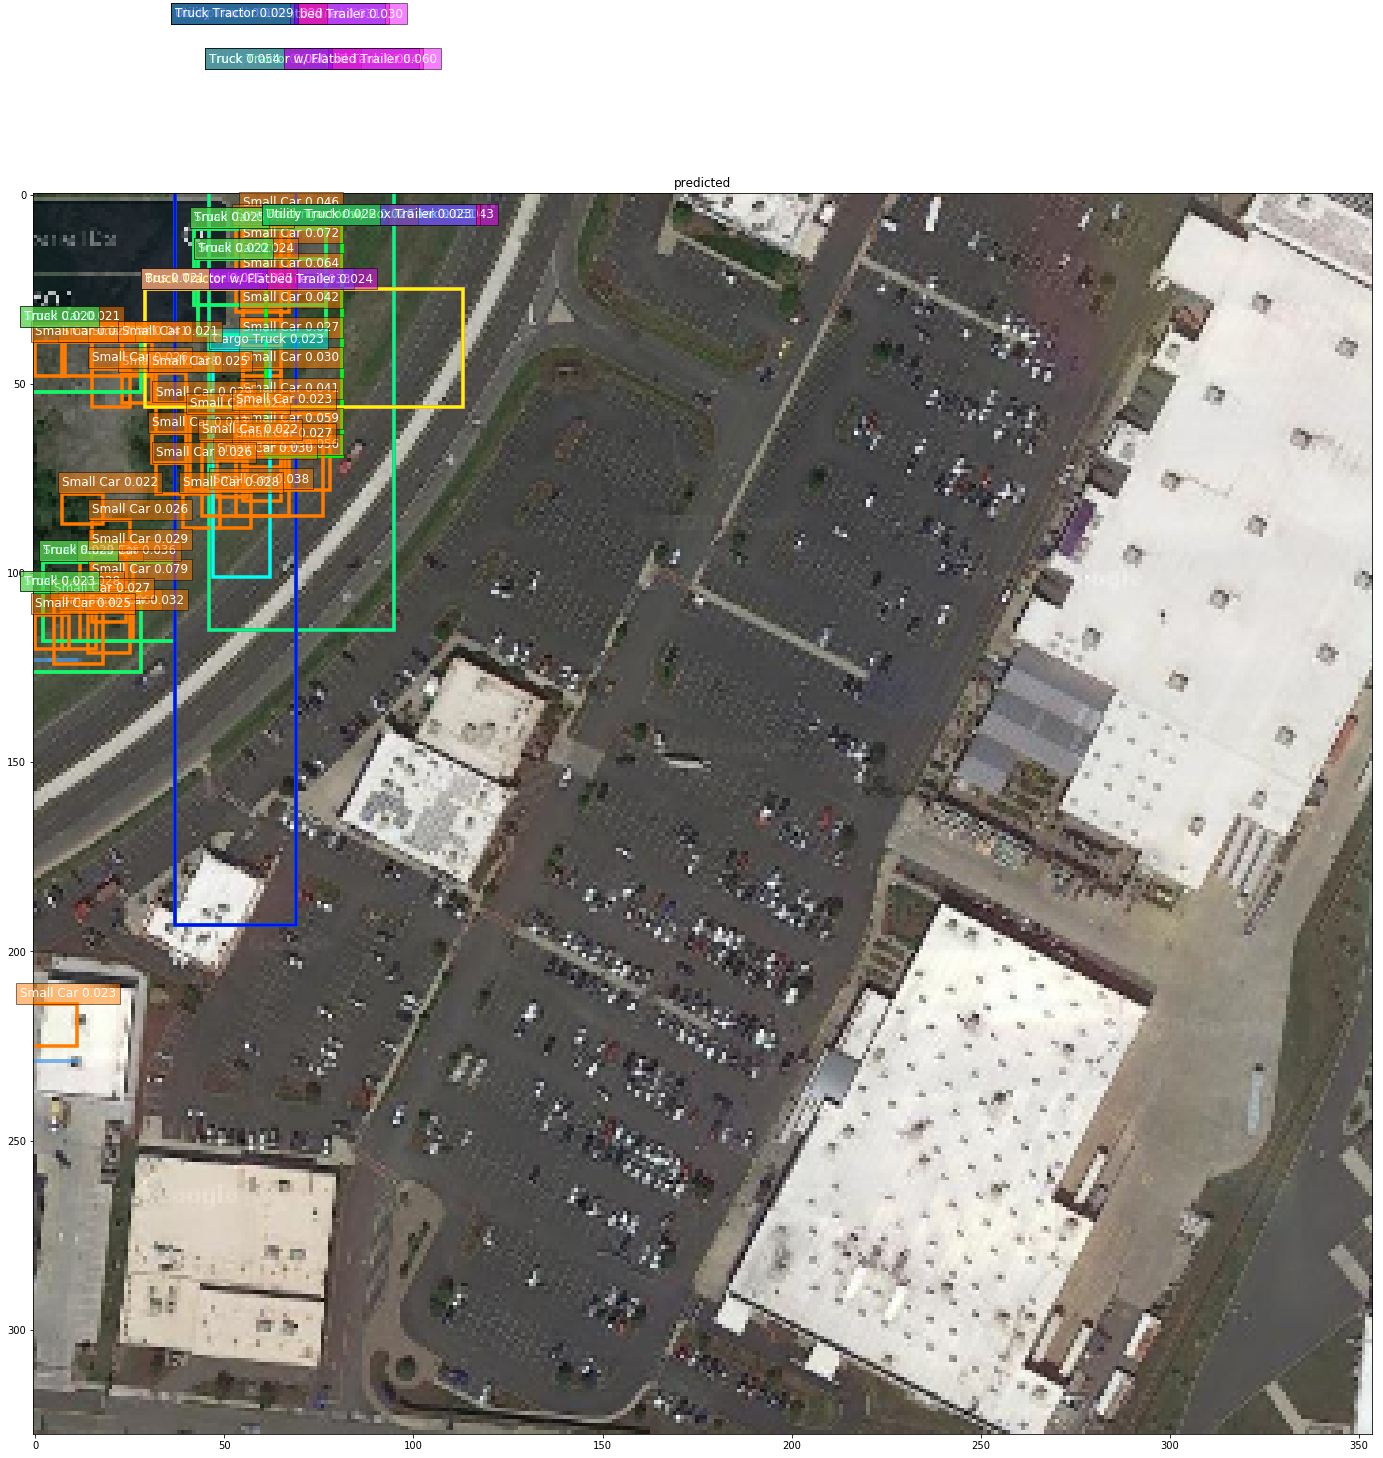

In [42]:
#lets plot the results we first load the true labels
import matplotlib.pyplot as plt
%matplotlib inline

#lbls = gcv.data.transforms.bbox.resize(np.load('./data/test-lbls.npy'),(208,208),(328,328))

cid = np.array(output['cid'])
scores = np.array(output['score'])
bbox = np.array(output['bbox'])

#On the left is our predictions, on the right is the ground truth.
fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(1,1,1)
ax.set_title('predicted')
gcv.utils.viz.plot_bbox(image, bbox, scores, cid, thresh=.02 ,class_names=classes,ax=ax)
#ax1 = fig.add_subplot(1,2,2)
#ax1.set_title('ground truth')
#gcv.utils.viz.plot_bbox(image, bboxes=lbls[:,:-1], labels=lbls[:,-1], class_names=classes,ax=ax1)

In [43]:
#We don't want to pay for resources we aren't using.
deployed_model.delete_endpoint()